
# STEP 1: Environment setup & data loading


In [4]:



import pandas as pd
import numpy as np


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

print("Libraries imported successfully.")




Libraries imported successfully.


In [2]:




IRENA_FILE = "IRENA_Electricity_Installed_Capacity_Solar_PV_Wind_2000_2023.csv"
WDI_FILE = "WorldBank_WDI_Core_Indicators_2000_2023.csv"
REN21_FILE = "REC_2021_Datapack.xlsx"
EI_FILE = "EI-Stats-Review-ALL-data.xlsx"

print("File paths defined.")





File paths defined.


In [6]:



irena_df = pd.read_csv(IRENA_FILE, encoding="latin1")
wdi_df = pd.read_csv(WDI_FILE, encoding="latin1")
ren21_df = pd.read_excel(REN21_FILE)
ei_df = pd.read_excel(EI_FILE)

print("Datasets loaded successfully.")




Datasets loaded successfully.



# Step 2: Dataset inspection & variable selection



In [7]:


irena_df.info()
wdi_df.info()
ren21_df.info()
ei_df.info()




<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16129 entries, ('Country/area', 'Technology', 'Data Type', 'Grid connection', 'Year') to ('Zimbabwe', 'Offshore wind energy', 'Electricity Installed Capacity (MW)', 'On-grid', '2023')
Data columns (total 1 columns):
 #   Column                                                                                   Non-Null Count  Dtype 
---  ------                                                                                   --------------  ----- 
 0   Electricity statistics by Country/area, Technology, Data Type, Grid connection and Year  16129 non-null  object
dtypes: object(1)
memory usage: 231.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 6384 non-null   object 
 1   country_code            6360 non-null   object 
 2   year              

In [16]:


irena_df = pd.read_csv(
    "IRENA_Electricity_Installed_Capacity_Solar_PV_Wind_2000_2023.csv",
    encoding="latin1",
    index_col=[0, 1, 2, 3, 4]
)


irena_df.index.names




FrozenList([None, None, None, None, None])

In [19]:


irena_df = pd.read_csv(
    "IRENA_Electricity_Installed_Capacity_Solar_PV_Wind_2000_2023.csv",
    encoding="latin1",
    index_col=[0, 1, 2, 3, 4]
)

irena_df.index = irena_df.index.set_names(
    ["country", "technology", "data_type", "grid_connection", "year"]
)

irena_df = irena_df.reset_index()
irena_df = irena_df.rename(columns={irena_df.columns[-1]: "capacity_mw"})

irena_df["year"] = pd.to_numeric(irena_df["year"], errors="coerce").astype("Int64")
irena_df["capacity_mw"] = pd.to_numeric(irena_df["capacity_mw"], errors="coerce")

irena_df = irena_df[
    irena_df["data_type"].str.contains("Installed Capacity", case=False, na=False) &
    irena_df["grid_connection"].str.contains("grid", case=False, na=False) &
    irena_df["technology"].str.contains(
        "solar|onshore wind|offshore wind",
        case=False,
        na=False
    )
]

irena_df = irena_df.pivot_table(
    index=["country", "year"],
    columns="technology",
    values="capacity_mw",
    aggfunc="sum"
).reset_index()

irena_df.columns = [
    "country",
    "year",
    "solar_pv_capacity",
    "onshore_wind_capacity",
    "offshore_wind_capacity"
]

irena_df.info()
display(irena_df.head())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 5376 non-null   object 
 1   year                    5376 non-null   Int64  
 2   solar_pv_capacity       5376 non-null   float64
 3   onshore_wind_capacity   5376 non-null   float64
 4   offshore_wind_capacity  5376 non-null   float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 215.4+ KB


,country,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity
0,Afghanistan,2000,0.0,0.0,0.0
1,Afghanistan,2001,0.0,0.0,0.0
2,Afghanistan,2002,0.0,0.0,0.0
3,Afghanistan,2003,0.0,0.0,0.0
4,Afghanistan,2004,0.0,0.0,0.0



# STEP 3: Missingness Diagnostics & Country Filtering



In [20]:



print("Rows:", irena_df.shape[0])
print("Countries:", irena_df["country"].nunique())
print("Years:", irena_df["year"].nunique())
print("Year range:", irena_df["year"].min(), "-", irena_df["year"].max())


missing_summary = irena_df.isna().mean().round(4) * 100
missing_summary


capacity_cols = [
    "solar_pv_capacity",
    "onshore_wind_capacity",
    "offshore_wind_capacity"
]

country_totals = irena_df.groupby("country")[capacity_cols].sum()
inactive_countries = country_totals[(country_totals.sum(axis=1) == 0)].index

len(inactive_countries)


irena_df_active = irena_df[~irena_df["country"].isin(inactive_countries)].copy()

print("Remaining countries:", irena_df_active["country"].nunique())
print("Remaining rows:", irena_df_active.shape[0])


data_quality = pd.DataFrame({
    "Metric": [
        "Initial observations",
        "Initial countries",
        "Final observations",
        "Final countries",
        "Missing values (%)",
        "Countries removed (zero capacity)"
    ],
    "Value": [
        irena_df.shape[0],
        irena_df["country"].nunique(),
        irena_df_active.shape[0],
        irena_df_active["country"].nunique(),
        missing_summary.mean(),
        len(inactive_countries)
    ]
})

data_quality


irena_df_active.info()
display(irena_df_active.head())




Rows: 5376
Countries: 224
Years: 24
Year range: 2000 - 2023
Remaining countries: 211
Remaining rows: 5064
<class 'pandas.core.frame.DataFrame'>
Index: 5064 entries, 0 to 5375
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 5064 non-null   object 
 1   year                    5064 non-null   Int64  
 2   solar_pv_capacity       5064 non-null   float64
 3   onshore_wind_capacity   5064 non-null   float64
 4   offshore_wind_capacity  5064 non-null   float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 242.3+ KB


,country,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity
0,Afghanistan,2000,0.0,0.0,0.0
1,Afghanistan,2001,0.0,0.0,0.0
2,Afghanistan,2002,0.0,0.0,0.0
3,Afghanistan,2003,0.0,0.0,0.0
4,Afghanistan,2004,0.0,0.0,0.0




# STEP 4: Integration with World Bank (WDI) Indicators



In [21]:


wdi_df.info()
display(wdi_df.head())


wdi_df["year"] = pd.to_numeric(wdi_df["year"], errors="coerce").astype("Int64")
wdi_df["country"] = wdi_df["country"].astype(str)


wdi_df = wdi_df[
    (wdi_df["year"] >= irena_df_active["year"].min()) &
    (wdi_df["year"] <= irena_df_active["year"].max())
]


wdi_df = wdi_df[
    [
        "country",
        "year",
        "gdp_per_capita_usd",
        "population",
        "co2_emissions_kt",
        "electricity_access_pct",
        "energy_use_per_capita"
    ]
]


wdi_missing = wdi_df.isna().mean().round(4) * 100
wdi_missing


panel_df = pd.merge(
    irena_df_active,
    wdi_df,
    on=["country", "year"],
    how="left"
)


print("Final panel rows:", panel_df.shape[0])
print("Final panel countries:", panel_df["country"].nunique())

panel_df.info()
display(panel_df.head())


panel_df["total_wind_capacity"] = (
    panel_df["onshore_wind_capacity"] +
    panel_df["offshore_wind_capacity"]
)

panel_df["total_re_capacity"] = (
    panel_df["solar_pv_capacity"] +
    panel_df["total_wind_capacity"]
)

panel_df["log_gdp_per_capita"] = np.log(panel_df["gdp_per_capita_usd"])
panel_df["log_population"] = np.log(panel_df["population"])
panel_df["log_energy_use"] = np.log(panel_df["energy_use_per_capita"])


panel_df.isna().sum()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 6384 non-null   object 
 1   country_code            6360 non-null   object 
 2   year                    6384 non-null   int64  
 3   gdp_per_capita_usd      6194 non-null   float64
 4   population              6360 non-null   float64
 5   co2_emissions_kt        0 non-null      float64
 6   electricity_access_pct  6287 non-null   float64
 7   energy_use_per_capita   4656 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 399.1+ KB


,country,country_code,year,gdp_per_capita_usd,population,co2_emissions_kt,electricity_access_pct,energy_use_per_capita
0,Afghanistan,AF,2000,174.930991,20130327.0,NaN,4.4,NaN
1,Afghanistan,AF,2001,138.706822,20284307.0,NaN,9.3,NaN
2,Afghanistan,AF,2002,178.954088,21378117.0,NaN,14.1,NaN
3,Afghanistan,AF,2003,198.871116,22733049.0,NaN,19.0,NaN
4,Afghanistan,AF,2004,221.763654,23560654.0,NaN,23.8,NaN


Final panel rows: 5064
Final panel countries: 211
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 5064 non-null   object 
 1   year                    5064 non-null   Int64  
 2   solar_pv_capacity       5064 non-null   float64
 3   onshore_wind_capacity   5064 non-null   float64
 4   offshore_wind_capacity  5064 non-null   float64
 5   gdp_per_capita_usd      3704 non-null   float64
 6   population              3768 non-null   float64
 7   co2_emissions_kt        0 non-null      float64
 8   electricity_access_pct  3706 non-null   float64
 9   energy_use_per_capita   2780 non-null   float64
dtypes: Int64(1), float64(8), object(1)
memory usage: 400.7+ KB


,country,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,gdp_per_capita_usd,population,co2_emissions_kt,electricity_access_pct,energy_use_per_capita
0,Afghanistan,2000,0.0,0.0,0.0,174.930991,20130327.0,NaN,4.4,NaN
1,Afghanistan,2001,0.0,0.0,0.0,138.706822,20284307.0,NaN,9.3,NaN
2,Afghanistan,2002,0.0,0.0,0.0,178.954088,21378117.0,NaN,14.1,NaN
3,Afghanistan,2003,0.0,0.0,0.0,198.871116,22733049.0,NaN,19.0,NaN
4,Afghanistan,2004,0.0,0.0,0.0,221.763654,23560654.0,NaN,23.8,NaN


country                      0
year                         0
solar_pv_capacity            0
onshore_wind_capacity        0
offshore_wind_capacity       0
gdp_per_capita_usd        1360
population                1296
co2_emissions_kt          5064
electricity_access_pct    1358
energy_use_per_capita     2284
total_wind_capacity          0
total_re_capacity            0
log_gdp_per_capita        1360
log_population            1296
log_energy_use            2284
dtype: int64



# STEP 5: Missing-Data Treatment & Imputation Rules



In [24]:


panel_df = panel_df.drop(columns=["co2_emissions_kt"], errors="ignore")

panel_df = panel_df.sort_values(["country", "year"]).reset_index(drop=True)

panel_df["imp_gdp"] = panel_df["gdp_per_capita_usd"].isna().astype(int)
panel_df["imp_population"] = panel_df["population"].isna().astype(int)
panel_df["imp_electricity"] = panel_df["electricity_access_pct"].isna().astype(int)
panel_df["imp_energy_use"] = panel_df["energy_use_per_capita"].isna().astype(int)

panel_df["gdp_per_capita_usd"] = (
    panel_df
    .groupby("country")["gdp_per_capita_usd"]
    .transform(lambda x: x.interpolate(limit=2))
)

panel_df["population"] = (
    panel_df
    .groupby("country")["population"]
    .transform(lambda x: x.interpolate(limit=2))
)

panel_df["electricity_access_pct"] = (
    panel_df
    .groupby("country")["electricity_access_pct"]
    .transform(lambda x: x.interpolate(limit=2))
)

panel_df["energy_use_per_capita"] = (
    panel_df
    .groupby("country")["energy_use_per_capita"]
    .transform(lambda x: x.interpolate(limit=2))
)

panel_df["log_gdp_per_capita"] = np.log(panel_df["gdp_per_capita_usd"])
panel_df["log_population"] = np.log(panel_df["population"])
panel_df["log_energy_use"] = np.log(panel_df["energy_use_per_capita"])

imputation_summary = pd.DataFrame({
    "Variable": [
        "GDP per capita",
        "Population",
        "Electricity access",
        "Energy use per capita"
    ],
    "Imputed values": [
        panel_df["imp_gdp"].sum(),
        panel_df["imp_population"].sum(),
        panel_df["imp_electricity"].sum(),
        panel_df["imp_energy_use"].sum()
    ]
})

panel_df.isna().sum()
imputation_summary
panel_df.info()
panel_df.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 5064 non-null   object 
 1   year                    5064 non-null   Int64  
 2   solar_pv_capacity       5064 non-null   float64
 3   onshore_wind_capacity   5064 non-null   float64
 4   offshore_wind_capacity  5064 non-null   float64
 5   gdp_per_capita_usd      3710 non-null   float64
 6   population              3768 non-null   float64
 7   electricity_access_pct  3706 non-null   float64
 8   energy_use_per_capita   2874 non-null   float64
 9   total_wind_capacity     5064 non-null   float64
 10  total_re_capacity       5064 non-null   float64
 11  log_gdp_per_capita      3710 non-null   float64
 12  log_population          3768 non-null   float64
 13  log_energy_use          2874 non-null   float64
 14  imp_gdp                 5064 non-null   

,country,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,gdp_per_capita_usd,population,electricity_access_pct,energy_use_per_capita,total_wind_capacity,total_re_capacity,log_gdp_per_capita,log_population,log_energy_use,imp_gdp,imp_population,imp_electricity,imp_energy_use
0,Afghanistan,2000,0.0,0.0,0.0,174.930991,20130327.0,4.4,NaN,0.0,0.0,5.164392,16.817738,NaN,0,0,0,1
1,Afghanistan,2001,0.0,0.0,0.0,138.706822,20284307.0,9.3,NaN,0.0,0.0,4.932363,16.825358,NaN,0,0,0,1
2,Afghanistan,2002,0.0,0.0,0.0,178.954088,21378117.0,14.1,NaN,0.0,0.0,5.187129,16.877878,NaN,0,0,0,1
3,Afghanistan,2003,0.0,0.0,0.0,198.871116,22733049.0,19.0,NaN,0.0,0.0,5.292657,16.939330,NaN,0,0,0,1
4,Afghanistan,2004,0.0,0.0,0.0,221.763654,23560654.0,23.8,NaN,0.0,0.0,5.401612,16.975089,NaN,0,0,0,1




# STEP 6: Exploratory Data Analysis (EDA)



In [25]:


desc_stats = panel_df[
    [
        "solar_pv_capacity",
        "onshore_wind_capacity",
        "offshore_wind_capacity",
        "total_re_capacity",
        "gdp_per_capita_usd",
        "population",
        "electricity_access_pct",
        "energy_use_per_capita"
    ]
].describe()

desc_stats




,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,total_re_capacity,gdp_per_capita_usd,population,electricity_access_pct,energy_use_per_capita
count,5064.000000,5064.000000,5064.000000,5.064000e+03,3710.000000,3.768000e+03,3706.000000,2874.000000
mean,70.661291,1513.442289,1290.458118,2.874562e+03,13937.068720,3.670099e+07,81.140340,2378.489713
std,956.433856,12513.188270,13584.681056,2.626029e+04,19676.038081,1.498006e+08,29.110452,2964.298982
min,0.000000,0.000000,0.000000,0.000000e+00,109.593814,9.544000e+03,0.800000,9.727288
25%,0.000000,0.000000,0.000000,0.000000e+00,1580.563837,1.219356e+06,70.325000,560.197031
50%,0.000000,0.000000,0.220000,2.000000e+00,5141.779434,6.825680e+06,98.900000,1381.804488
75%,0.000000,41.900000,23.000000,1.178200e+02,18629.317824,2.073615e+07,100.000000,2856.583195
max,37290.000000,404050.000000,608920.000000,1.050260e+06,134965.815442,1.438070e+09,100.000000,21557.475076


In [26]:


global_trends = (
    panel_df
    .groupby("year")[
        [
            "solar_pv_capacity",
            "onshore_wind_capacity",
            "offshore_wind_capacity",
            "total_re_capacity"
        ]
    ]
    .sum()
    .reset_index()
)

global_trends




,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,total_re_capacity
0,2000,66.95,16881.33,755.69,17703.97
1,2001,75.95,23872.38,1022.80,24971.13
2,2002,239.95,30474.36,1341.02,32055.33
3,2003,510.55,38142.98,1847.47,40501.00
4,2004,595.75,47057.51,2915.31,50568.57
5,2005,685.75,57770.35,4390.35,62846.45
6,2006,883.75,72252.81,5911.64,79048.20
7,2007,1094.25,90411.65,8265.92,99771.82
8,2008,1442.45,114019.74,14444.86,129907.05
9,2009,2133.55,147956.61,22483.40,172573.56


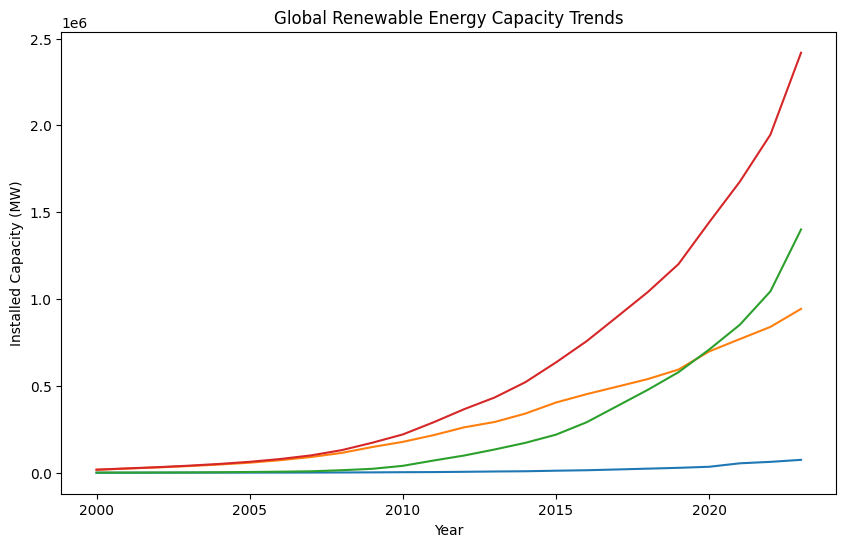

In [27]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(global_trends["year"], global_trends["solar_pv_capacity"])
plt.plot(global_trends["year"], global_trends["onshore_wind_capacity"])
plt.plot(global_trends["year"], global_trends["offshore_wind_capacity"])
plt.plot(global_trends["year"], global_trends["total_re_capacity"])
plt.xlabel("Year")
plt.ylabel("Installed Capacity (MW)")
plt.title("Global Renewable Energy Capacity Trends")
plt.show()




In [28]:


top_countries = (
    panel_df
    .groupby("country")["total_re_capacity"]
    .max()
    .sort_values(ascending=False)
    .head(15)
)

top_countries




country
China                                                         1050260.00
United States of America (the)                                 285966.90
Germany                                                        144368.00
India                                                          115498.56
Japan                                                           92437.04
Brazil                                                          67049.33
Spain                                                           60448.11
United Kingdom of Great Britain and Northern Ireland (the)      46438.21
Australia                                                       43579.94
Italy                                                           41658.70
France                                                          40157.34
Netherlands (Kingdom of the)                                    32008.76
Poland                                                          25770.85
Republic of Korea (the)                    

In [29]:


corr_matrix = panel_df[
    [
        "log_gdp_per_capita",
        "log_population",
        "log_energy_use",
        "electricity_access_pct",
        "total_re_capacity"
    ]
].corr()

corr_matrix




,log_gdp_per_capita,log_population,log_energy_use,electricity_access_pct,total_re_capacity
log_gdp_per_capita,1.000000,-0.253789,0.845150,0.728215,0.080116
log_population,-0.253789,1.000000,-0.198849,-0.165896,0.185957
log_energy_use,0.845150,-0.198849,1.000000,0.689415,0.068859
electricity_access_pct,0.728215,-0.165896,0.689415,1.000000,0.066821
total_re_capacity,0.080116,0.185957,0.068859,0.066821,1.000000


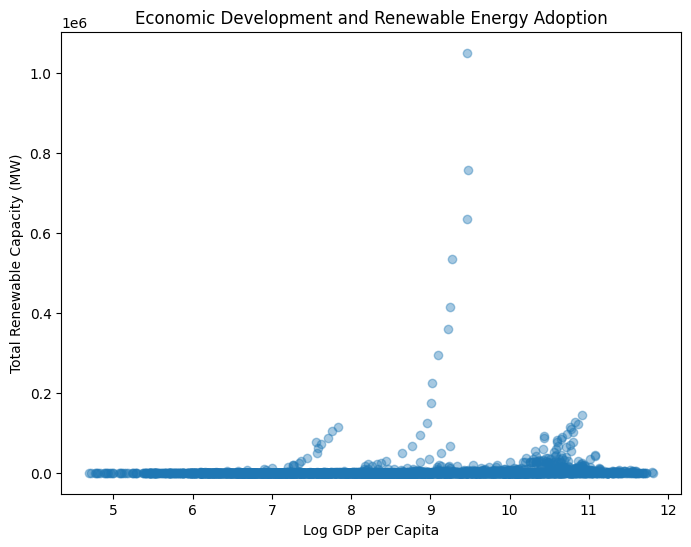

In [30]:


plt.figure(figsize=(8, 6))
plt.scatter(panel_df["log_gdp_per_capita"], panel_df["total_re_capacity"], alpha=0.4)
plt.xlabel("Log GDP per Capita")
plt.ylabel("Total Renewable Capacity (MW)")
plt.title("Economic Development and Renewable Energy Adoption")
plt.show()




In [31]:


eda_summary = pd.DataFrame({
    "Metric": [
        "Total observations",
        "Countries",
        "Years covered",
        "Mean total RE capacity (MW)",
        "Median total RE capacity (MW)"
    ],
    "Value": [
        panel_df.shape[0],
        panel_df["country"].nunique(),
        panel_df["year"].nunique(),
        panel_df["total_re_capacity"].mean(),
        panel_df["total_re_capacity"].median()
    ]
})

eda_summary




,Metric,Value
0,Total observations,5064.000000
1,Countries,211.000000
2,Years covered,24.000000
3,Mean total RE capacity (MW),2874.561698
4,Median total RE capacity (MW),2.000000




# Step 7: Econometric Modelling (Panel Regression)



In [33]:


!pip install linearmodels



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 25.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.5 MB/s eta 0:00:00

   -------------------- ------------------- 2/4 [formulaic]
   ------------------------------ --------- 3/4 [linearmodels]
   ------------------------------ --------- 3/4 [linearmodels]
   ------------------------------ --------- 3/4 [linearmodels]
   ------------------------------ --------- 3/4 [linearmodels]
   ---------------------------------------- 4/4 [linearmodels]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:



import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor

panel_df["log_total_re_capacity"] = np.log(panel_df["total_re_capacity"] + 1)

if not isinstance(panel_df.index, pd.MultiIndex):
    panel_df = panel_df.set_index(["country", "year"])

X = panel_df[
    [
        "log_gdp_per_capita",
        "log_population",
        "electricity_access_pct",
        "log_energy_use"
    ]
]

X = sm.add_constant(X)

y = panel_df["log_total_re_capacity"]

pooled_ols = sm.OLS(y, X, missing="drop").fit(cov_type="HC3")

fe_model = PanelOLS(
    y,
    X,
    entity_effects=True
).fit(cov_type="clustered", cluster_entity=True)

re_model = RandomEffects(
    y,
    X
).fit(cov_type="clustered", cluster_entity=True)

comparison = compare({
    "Fixed Effects": fe_model,
    "Random Effects": re_model
})

X_vif = X.replace([np.inf, -np.inf], np.nan).dropna()

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

vif_data


model_summary = pd.DataFrame({
    "Model": ["Pooled OLS", "Fixed Effects", "Random Effects"],
    "R_squared": [
        pooled_ols.rsquared,
        fe_model.rsquared,
        re_model.rsquared
    ]
})

pooled_ols.summary(), fe_model.summary, re_model.summary, comparison, vif_data, model_summary




D:\Python\Lib\site-packages\linearmodels\panel\model.py:1258: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Python\Lib\site-packages\linearmodels\panel\model.py:2751: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     log_total_re_capacity   R-squared:                       0.595
 Model:                               OLS   Adj. R-squared:                  0.595
 Method:                    Least Squares   F-statistic:                     1387.
 Date:                   Wed, 17 Dec 2025   Prob (F-statistic):               0.00
 Time:                           23:53:45   Log-Likelihood:                -6225.9
 No. Observations:                   2850   AIC:                         1.246e+04
 Df Residuals:                       2845   BIC:                         1.249e+04
 Df Model:                              4                                         
 Covariance Type:                     HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------



# Step 8: Forecasting



In [38]:


!pip install prophet




   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.1 MB 8.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/12.1 MB 4.8 MB/s eta 0:00:03
   ----------- ---------------------------- 3.4/12.1 MB 5.6 MB/s eta 0:00:02
   -------------------- ------------------- 6.3/12.1 MB 7.7 MB/s eta 0:00:01
   ------------------------- -------------- 7.9/12.1 MB 8.1 MB/s eta 0:00:01
   ----------------------------- ---------- 8.9/12.1 MB 7.5 MB/s eta 0:00:01
   -------------------------------- ------- 10.0/12.1 MB 7.1 MB/s eta 0:00:01
   ------------------------------------ --- 11.0/12.1 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.3 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.3 MB/s eta 0:00:00

   ---------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:42 - cmdstanpy - INFO - Chain [1] done processing
D:\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


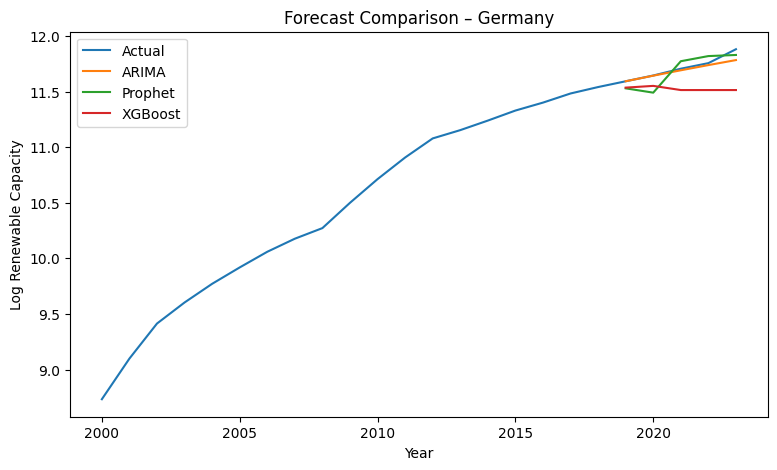

00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing
D:\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


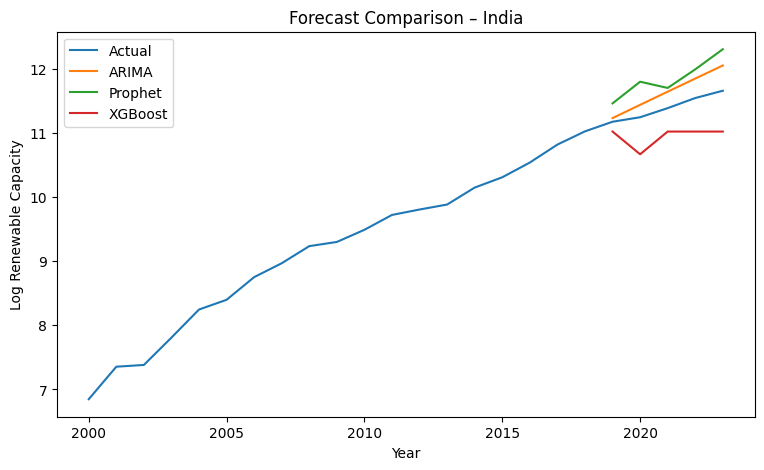

00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing
D:\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


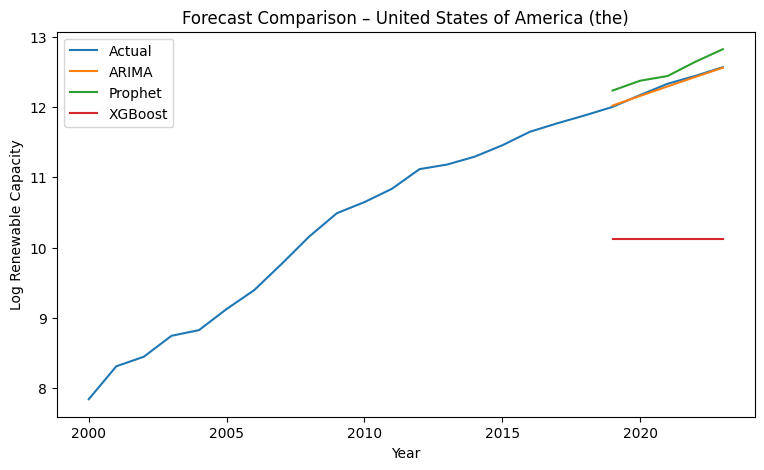

,Country,Model,RMSE,MAE,MAPE
0,Germany,ARIMA,0.044782,0.026184,0.203905
1,Germany,Prophet,0.088320,0.079995,0.630211
2,Germany,XGBoost,0.220004,0.190229,1.489443
3,India,ARIMA,0.265870,0.240775,1.929395
4,India,Prophet,0.470325,0.449686,3.617595
5,India,XGBoost,0.483411,0.450979,3.623572
6,United States of America (the),ARIMA,0.021133,0.018285,0.137751
7,United States of America (the),Prophet,0.206350,0.200323,1.506337
8,United States of America (the),XGBoost,2.191251,2.182215,16.388610


In [39]:


import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

forecast_df = panel_df.reset_index()

forecast_df["log_total_re_capacity"] = np.log(forecast_df["total_re_capacity"] + 1)

countries_focus = [
    "Germany",
    "India",
    "United States of America (the)"
]

results = []

def evaluate_forecast(y_true, y_pred, model_name, country):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    results.append({
        "Country": country,
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    })

for country in countries_focus:
    df_c = forecast_df[forecast_df["country"] == country].sort_values("year")
    
    y = df_c["log_total_re_capacity"].values
    years = df_c["year"].values
    
    split = int(len(y) * 0.8)
    y_train, y_test = y[:split], y[split:]
    years_test = years[split:]
    
    arima_model = ARIMA(y_train, order=(1,1,1)).fit()
    arima_forecast = arima_model.forecast(steps=len(y_test))
    evaluate_forecast(y_test, arima_forecast, "ARIMA", country)
    
    prophet_df = df_c[["year", "log_total_re_capacity"]].copy()
    prophet_df.columns = ["ds", "y"]
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"], format="%Y")
    
    prophet_train = prophet_df.iloc[:split]
    prophet_test = prophet_df.iloc[split:]
    
    prophet_model = Prophet()
    prophet_model.fit(prophet_train)
    future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq="Y")
    prophet_forecast = prophet_model.predict(future)["yhat"].iloc[-len(prophet_test):].values
    evaluate_forecast(prophet_test["y"].values, prophet_forecast, "Prophet", country)
    
    features = [
        "log_gdp_per_capita",
        "log_population",
        "electricity_access_pct",
        "log_energy_use"
    ]
    
    X = df_c[features].values
    X_train, X_test = X[:split], X[split:]
    
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    xgb.fit(X_train, y_train)
    xgb_forecast = xgb.predict(X_test)
    evaluate_forecast(y_test, xgb_forecast, "XGBoost", country)
    
    plt.figure(figsize=(9,5))
    plt.plot(years, y, label="Actual")
    plt.plot(years_test, arima_forecast, label="ARIMA")
    plt.plot(years_test, prophet_forecast, label="Prophet")
    plt.plot(years_test, xgb_forecast, label="XGBoost")
    plt.title(f"Forecast Comparison – {country}")
    plt.xlabel("Year")
    plt.ylabel("Log Renewable Capacity")
    plt.legend()
    plt.show()

forecast_results = pd.DataFrame(results)
forecast_results







# Step 9: Explainability (SHAP analysis for XGBoost)



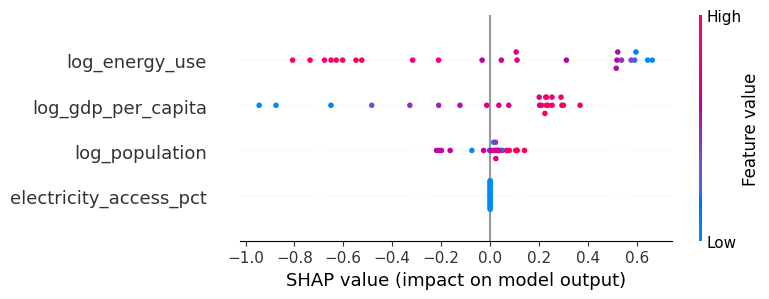

In [40]:


import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

shap.initjs()

country_explain = "Germany"

df_shap = (
    panel_df
    .reset_index()
    .query("country == @country_explain")
    .sort_values("year")
)

features = [
    "log_gdp_per_capita",
    "log_population",
    "electricity_access_pct",
    "log_energy_use"
]

X_shap = df_shap[features].replace([np.inf, -np.inf], np.nan).dropna()
y_shap = np.log(df_shap.loc[X_shap.index, "total_re_capacity"] + 1)

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_shap, y_shap)

explainer = shap.Explainer(xgb_model, X_shap)
shap_values = explainer(X_shap)

shap.summary_plot(shap_values, X_shap)




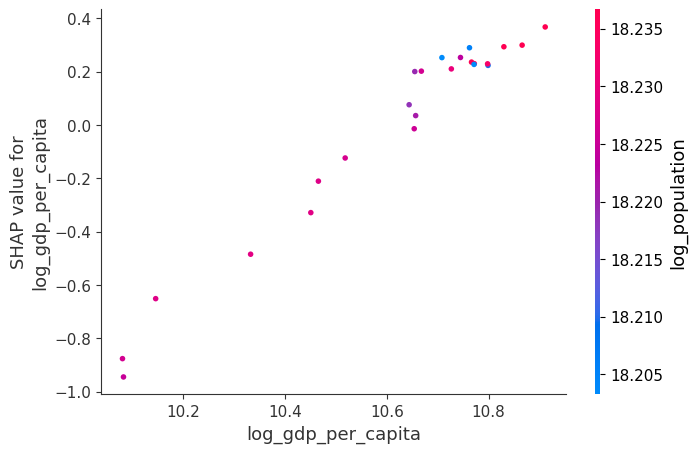

In [41]:


shap.dependence_plot(
    "log_gdp_per_capita",
    shap_values.values,
    X_shap
)




In [42]:


panel_df.info()
panel_df.head()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5064 entries, ('Afghanistan', np.int64(2000)) to ('Zimbabwe', np.int64(2023))
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   solar_pv_capacity       5064 non-null   float64
 1   onshore_wind_capacity   5064 non-null   float64
 2   offshore_wind_capacity  5064 non-null   float64
 3   gdp_per_capita_usd      3710 non-null   float64
 4   population              3768 non-null   float64
 5   electricity_access_pct  3706 non-null   float64
 6   energy_use_per_capita   2874 non-null   float64
 7   total_wind_capacity     5064 non-null   float64
 8   total_re_capacity       5064 non-null   float64
 9   log_gdp_per_capita      3710 non-null   float64
 10  log_population          3768 non-null   float64
 11  log_energy_use          2874 non-null   float64
 12  imp_gdp                 5064 non-null   int64  
 13  imp_population          5064 non-null  

solar_pv_capacity  onshore_wind_capacity  offshore_wind_capacity  gdp_per_capita_usd  population  \
country     year                                                                                                     
Afghanistan 2000                0.0                    0.0                     0.0          174.930991  20130327.0   
            2001                0.0                    0.0                     0.0          138.706822  20284307.0   
            2002                0.0                    0.0                     0.0          178.954088  21378117.0   
            2003                0.0                    0.0                     0.0          198.871116  22733049.0   
            2004                0.0                    0.0                     0.0          221.763654  23560654.0   

                  electricity_access_pct  energy_use_per_capita  total_wind_capacity  total_re_capacity  \
country     year                                                                                          
Afghanistan 2000                     4.4                    NaN                  0.0                0.0   
            2001                     9.3                    NaN                  0.0                0.0   
            2002                    14.1                    NaN                  0.0                0.0   
            2003                    19.0                    NaN                  0.0                0.0   
            2004                    23.8                    NaN                  0.0                0.0   

                  log_gdp_per_capita  log_population  log_energy_use  imp_gdp  imp_population  imp_electricity  \
country     year                                                                                                 
Afghanistan 2000            5.164392       16.817738             NaN        0               0                0   
            2001            4.932363       16.825358             NaN        0               0                0   
            2002            5.187129       16.877878             NaN        0               0                0   
            2003            5.292657       16.939330             NaN        0               0                0   
            2004            5.401612       16.975089             NaN        0               0                0   

                  imp_energy_use  log_total_re_capacity  
country     year                                         
Afghanistan 2000               1                    0.0  
            2001               1                    0.0  
            2002               1                    0.0  
            2003               1                    0.0  
            2004               1                    0.0

In [43]:


desc_stats




,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,total_re_capacity,gdp_per_capita_usd,population,electricity_access_pct,energy_use_per_capita
count,5064.000000,5064.000000,5064.000000,5.064000e+03,3710.000000,3.768000e+03,3706.000000,2874.000000
mean,70.661291,1513.442289,1290.458118,2.874562e+03,13937.068720,3.670099e+07,81.140340,2378.489713
std,956.433856,12513.188270,13584.681056,2.626029e+04,19676.038081,1.498006e+08,29.110452,2964.298982
min,0.000000,0.000000,0.000000,0.000000e+00,109.593814,9.544000e+03,0.800000,9.727288
25%,0.000000,0.000000,0.000000,0.000000e+00,1580.563837,1.219356e+06,70.325000,560.197031
50%,0.000000,0.000000,0.220000,2.000000e+00,5141.779434,6.825680e+06,98.900000,1381.804488
75%,0.000000,41.900000,23.000000,1.178200e+02,18629.317824,2.073615e+07,100.000000,2856.583195
max,37290.000000,404050.000000,608920.000000,1.050260e+06,134965.815442,1.438070e+09,100.000000,21557.475076


In [44]:


global_trends




,year,solar_pv_capacity,onshore_wind_capacity,offshore_wind_capacity,total_re_capacity
0,2000,66.95,16881.33,755.69,17703.97
1,2001,75.95,23872.38,1022.80,24971.13
2,2002,239.95,30474.36,1341.02,32055.33
3,2003,510.55,38142.98,1847.47,40501.00
4,2004,595.75,47057.51,2915.31,50568.57
5,2005,685.75,57770.35,4390.35,62846.45
6,2006,883.75,72252.81,5911.64,79048.20
7,2007,1094.25,90411.65,8265.92,99771.82
8,2008,1442.45,114019.74,14444.86,129907.05
9,2009,2133.55,147956.61,22483.40,172573.56


In [45]:


top_countries




country
China                                                         1050260.00
United States of America (the)                                 285966.90
Germany                                                        144368.00
India                                                          115498.56
Japan                                                           92437.04
Brazil                                                          67049.33
Spain                                                           60448.11
United Kingdom of Great Britain and Northern Ireland (the)      46438.21
Australia                                                       43579.94
Italy                                                           41658.70
France                                                          40157.34
Netherlands (Kingdom of the)                                    32008.76
Poland                                                          25770.85
Republic of Korea (the)                    

In [46]:


corr_matrix




,log_gdp_per_capita,log_population,log_energy_use,electricity_access_pct,total_re_capacity
log_gdp_per_capita,1.000000,-0.253789,0.845150,0.728215,0.080116
log_population,-0.253789,1.000000,-0.198849,-0.165896,0.185957
log_energy_use,0.845150,-0.198849,1.000000,0.689415,0.068859
electricity_access_pct,0.728215,-0.165896,0.689415,1.000000,0.066821
total_re_capacity,0.080116,0.185957,0.068859,0.066821,1.000000


In [47]:


pooled_ols.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_total_re_capacity   R-squared:                       0.595
Model:                               OLS   Adj. R-squared:                  0.595
Method:                    Least Squares   F-statistic:                     1387.
Date:                   Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                           00:32:18   Log-Likelihood:                -6225.9
No. Observations:                   2850   AIC:                         1.246e+04
Df Residuals:                       2845   BIC:                         1.249e+04
Df Model:                              4                                         
Covariance Type:                     HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -24.0885      0.490    -49.157      0.000     -25.049     -23.128
log_gdp_per_capita         2.0757      0.048     43.093      0.000       1.981       2.170
log_population             1.0328      0.025     41.512      0.000       0.984       1.082
electricity_access_pct     0.0135      0.002      6.815      0.000       0.010       0.017
log_energy_use            -1.1472      0.066    -17.466      0.000      -1.276      -1.018
==============================================================================
Omnibus:                      106.431   Durbin-Watson:                   0.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.109
Skew:                          -0.256   Prob(JB):                     9.84e-16
Kurtosis:                       2.435   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:


fe_model.summary




Dep. Variable:,log_total_re_capacity,R-squared:,0.4716
Estimator:,PanelOLS,R-squared (Between):,-2.6336
No. Observations:,2850,R-squared (Within):,0.4716
Date:,"Wed, Dec 17 2025",R-squared (Overall):,-0.8098
Time:,23:53:45,Log-likelihood,-5153.3
Cov. Estimator:,Clustered,,
,,F-statistic:,605.12
Entities:,134,P-value,0.0000
Avg Obs:,21.269,Distribution:,"F(4,2712)"
Min Obs:,6.0000,,
Max Obs:,24.000,F-statistic (robust):,68.808


In [49]:


re_model.summary

Dep. Variable:,log_total_re_capacity,R-squared:,0.4643
Estimator:,RandomEffects,R-squared (Between):,0.6271
No. Observations:,2850,R-squared (Within):,0.4558
Date:,"Wed, Dec 17 2025",R-squared (Overall):,0.5589
Time:,23:53:45,Log-likelihood,-5279.6
Cov. Estimator:,Clustered,,
,,F-statistic:,616.54
Entities:,134,P-value,0.0000
Avg Obs:,21.269,Distribution:,"F(4,2845)"
Min Obs:,6.0000,,
Max Obs:,24.000,F-statistic (robust):,120.06


In [50]:


comparison


,Fixed Effects,Random Effects
Dep. Variable,log_total_re_capacity,log_total_re_capacity
Estimator,PanelOLS,RandomEffects
No. Observations,2850,2850
Cov. Est.,Clustered,Clustered
R-squared,0.4716,0.4643
R-Squared (Within),0.4716,0.4558
R-Squared (Between),-2.6336,0.6271
R-Squared (Overall),-0.8098,0.5589
F-statistic,605.12,616.54
P-value (F-stat),0.0000,0.0000


In [51]:


vif_data




,Variable,VIF
0,const,176.675914
1,log_gdp_per_capita,3.952011
2,log_population,1.075614
3,electricity_access_pct,2.084202
4,log_energy_use,3.746862
